<a href="https://colab.research.google.com/github/gimenopea/EMSE6574/blob/master/Analysis_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Data Prep

In [ ]:
#preliminary clean-up function for all the dataframes

def clean_up_df(df):
  #drop black columns
  df.dropna(how='all',axis=1,inplace=True)
  
  #tranpose so the columns become indexes
  dft = df.T
  
  #make the index datetime format and set the year to 2020
  dft.index = pd.to_datetime(dft.index,format='%d-%b')
  dft.index = dft.index.map(lambda t: t.replace(year=2020))
  dft = dft.asfreq('d')

  #drop the All column if it exists
  try:
    dft.drop('All',axis=1,inplace=True)
  except KeyError:
    print('no All Column, all good')
  
  #make any null values 0  
  dft.loc[min(dft.index)-pd.Timedelta('1 days'),:] = None
  dft.sort_index(inplace=True)
  dft.fillna(0,inplace=True)

  #undo the cumulative sum and remove the first row
  dft = dft - dft.shift()
  dft.drop(dft.index[0],axis=0,inplace=True)
  dft = dft.astype(int)

  return dft

def wide_to_long(df):
  dd = df.reset_index()
  
  try:
    dd.drop('total_cases',axis=1)
  except KeyError:
    print('no column')
  
  c = [x for x in dd.columns.values if x != 'index']

  ddf = pd.melt(dd,id_vars=['index'],value_vars=c,value_name='total_cases')
  ddf = ddf.set_index('index')
  ddf.index.name = 'date'
  return ddf


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_cases_by_ward = pd.read_csv('/content/drive/MyDrive/EMSE 6574 Final Project Files/December-05-2020-Data/cases-by-ward-dec-5.csv',index_col='Ward')
df_cases_by_ward = clean_up_df(df_cases_by_ward)
df_cases_by_ward



FileNotFoundError: ignored

In [ ]:
df_lives_by_ward = pd.read_csv('/content/drive/MyDrive/EMSE 6574 Final Project Files/December-05-2020-Data/lives_lost_by_ward_dec-05.csv',index_col='Ward')
df_lives_by_ward = clean_up_df(df_lives_by_ward)
df_lives_by_ward

Ward,1,2,3,4,5,6,7,8,Experienced Homelessness,Unknown
2020-04-19,6,1,9,14,12,18,16,22,7,0
2020-04-20,0,0,0,1,1,3,0,2,0,0
2020-04-21,0,0,1,1,4,2,1,5,1,0
2020-04-22,2,2,0,1,2,2,1,1,1,0
2020-04-23,0,1,2,1,2,0,5,3,0,0
...,...,...,...,...,...,...,...,...,...,...
2020-12-01,0,0,1,0,1,2,1,0,0,0
2020-12-02,0,0,0,1,0,1,0,0,0,0
2020-12-03,0,0,0,0,1,0,0,0,0,0
2020-12-04,0,0,0,1,0,0,0,1,0,0


In [ ]:
cases_df = wide_to_long(df_cases_by_ward)
cases_df

no column


,Ward,total_cases
date,,
2020-03-31,1,65
2020-04-01,1,10
2020-04-02,1,9
2020-04-03,1,16
2020-04-04,1,7
...,...,...
2020-12-01,Unknown,5
2020-12-02,Unknown,7
2020-12-03,Unknown,20


In [ ]:
lives_df = wide_to_long(df_lives_by_ward)
lives_df

no column


,Ward,total_cases
date,,
2020-04-19,1,6
2020-04-20,1,0
2020-04-21,1,0
2020-04-22,1,2
2020-04-23,1,0
...,...,...
2020-12-01,Unknown,0
2020-12-02,Unknown,0
2020-12-03,Unknown,0


In [ ]:
cases_df.index

DatetimeIndex(['2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03',
               '2020-04-04', '2020-04-05', '2020-04-06', '2020-04-07',
               '2020-04-08', '2020-04-09',
               ...
               '2020-11-26', '2020-11-27', '2020-11-28', '2020-11-29',
               '2020-11-30', '2020-12-01', '2020-12-02', '2020-12-03',
               '2020-12-04', '2020-12-05'],
              dtype='datetime64[ns]', name='date', length=2250, freq=None)

In [ ]:
lives_df['Experienced Homelessness'] = 'Unknown'

In [ ]:
lives_df['Ward'] = lives_df['Ward'].apply(lambda x: 'Unknown' if x == 'Experienced Homelessness' else x)
lives_df['Ward'].value_counts()

Unknown    462
5          231
6          231
2          231
8          231
1          231
3          231
4          231
7          231
Name: Ward, dtype: int64

In [ ]:
def scatter_df(df,xlabel="y",ylabel="y", title="Plot"):
  from matplotlib import dates
  ax = df.reset_index().plot(x = 'date', y= 'total_cases', figsize=(14,8),title=title, kind='scatter')
  ax.autoscale(axis='both',tight=True)
  ax.set(xlabel = xlabel, ylabel = ylabel)
  ax.xaxis.set_major_locator(dates.MonthLocator())

def line_df(df,xlabel="y",ylabel="y", title="Plot"):
  from matplotlib import dates
  ax = df.plot(figsize=(14,8),title=title)
  ax.autoscale(axis='both',tight=True)
  ax.set(xlabel = xlabel, ylabel = ylabel)
  ax.xaxis.set_major_locator(dates.MonthLocator())

In [ ]:
resampled_cases_daily = cases_df.resample('D').sum()
resampled_cases_weekly = cases_df.resample('W').sum()
resampled_cases_monthly = cases_df.resample('M').sum()

In [ ]:
resampled_cases_weekly

,total_cases
date,
2020-04-05,1096
2020-04-12,859
2020-04-19,972
2020-04-26,965
2020-05-03,1278
2020-05-10,1219
2020-05-17,881
2020-05-24,955
2020-05-31,632


# Model 1: Linear Regression

In [ ]:
def linear_prep_train(df, type=None):
  types = {'daily': 'weeks_since_start', 'weekly': 'weeks_since_start','monthly':'months_since_start'}
  
  df[f'{types[type]}'] = [x for x in range(len(df))]

  if type == 'daily':
    X_train = df[:-30][[types[type]]]
    y_train = df[:-30][['total_cases']]

    X_test = df[-30:][[types[type]]]
    y_test = df[-30:][['total_cases']]

  elif type == 'weekly':
    X_train = df[:-4][[types[type]]]
    y_train = df[:-4][['total_cases']]

    X_test = df[-4:][[types[type]]]
    y_test = df[-4:][['total_cases']]

  elif type == 'monthly':
    X_train = df[:-1][[types[type]]]
    y_train = df[:-1][['total_cases']]

    X_test = df[-1:][[types[type]]]
    y_test = df[-1:][['total_cases']]


  return X_train, y_train, X_test, y_test


In [ ]:
def linear_reg_train_and_evaluate(X_train, y_train, X_test, y_test):
  from sklearn.linear_model import LinearRegression
  from sklearn.metrics import mean_squared_error
  linear_reg = LinearRegression(fit_intercept=True)
  fitted_linear_reg = linear_reg.fit(X_train, y_train)
  linear_reg_r2 = fitted_linear_reg.score(X_test,y_test)
  linear_reg_rmse = mean_squared_error(y_test,fitted_linear_reg.predict(X_test),squared=False)
  print(f' RMSE: {linear_reg_rmse}')
  print(f' R2: {linear_reg_r2}')
  return fitted_linear_reg, linear_reg_r2,linear_reg_rmse

In [ ]:
def linear_plots(model, x, y, xlabel='xlabel',ylabel='ylabel',title='title'):
  fig,ax = plt.subplots(figsize=(12,8))
  plt.scatter(x,y)
  plt.plot(x,model.predict(x),color='red')
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title);

In [ ]:
def forecast_linear_reg(model, df, periods = None):
  forecast_range = np.arange(df.iloc[:,1].max()+1,df.iloc[:,1].max()+1+periods)
  predictions_df = pd.DataFrame(model.predict(forecast_range.reshape(-1,1)),index=forecast_range)
  predictions_df = predictions_df.reset_index().rename(columns={0:'total_cases','index':'interval'})
  predictions_df.index = pd.date_range(start='12/06/2020', periods=periods, freq='D')

  fig,ax = plt.subplots(figsize=(12,8))
  plt.plot(df.iloc[:,1],df['total_cases'])
  plt.plot(forecast_range,predictions_df['total_cases'],color='red')
  plt.xlabel('total cases')
  plt.ylabel('days since start')
  plt.title('Predictions');
  return predictions_df

In [ ]:
def forecast_poly_reg(model, df, periods = None):
  from sklearn.preprocessing import PolynomialFeatures
  poly_reg = PolynomialFeatures(degree=3)

  forecast_range = np.arange(df.iloc[:,1].max()+1,df.iloc[:,1].max()+1+periods)
  n_transformed = poly_reg.fit_transform(forecast_range.reshape(-1,1))
  predictions_df = pd.DataFrame(model.predict(n_transformed),index=forecast_range)
  predictions_df = predictions_df.reset_index().rename(columns={0:'total_cases','index':'interval'})
  predictions_df.index = pd.date_range(start='12/06/2020', periods=periods, freq='D')

  fig,ax = plt.subplots(figsize=(12,8))
  plt.scatter(df.iloc[:,1],df['total_cases'])
  plt.scatter(forecast_range,predictions_df['total_cases'],color='red')
  plt.xlabel('total cases')
  plt.ylabel('days since start')
  plt.title('Predictions');
  return predictions_df

In [ ]:
X_train, y_train, X_test, y_test = linear_prep_train(resampled_cases_daily, type='daily')

In [ ]:
daily_model, daily_r2, daily_rmse = linear_reg_train_and_evaluate(X_train, y_train, X_test, y_test)

 RMSE: 177.2217574065834
 R2: -3.6631612010791166


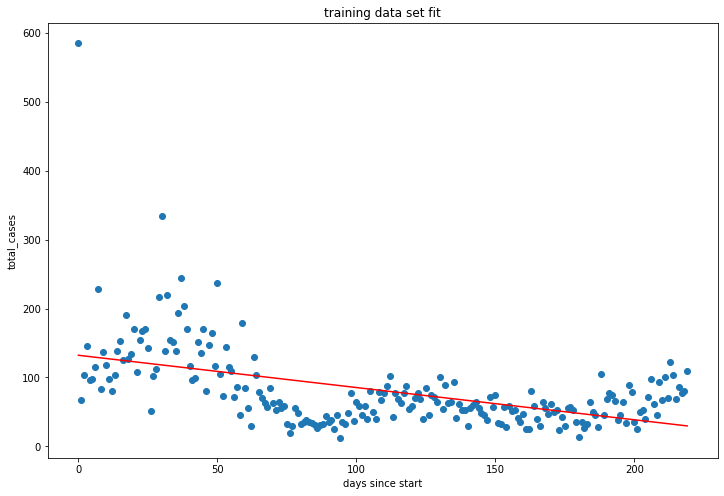

In [ ]:
linear_plots(daily_model,X_train,y_train,xlabel='days since start',ylabel='total_cases',title='training data set fit')

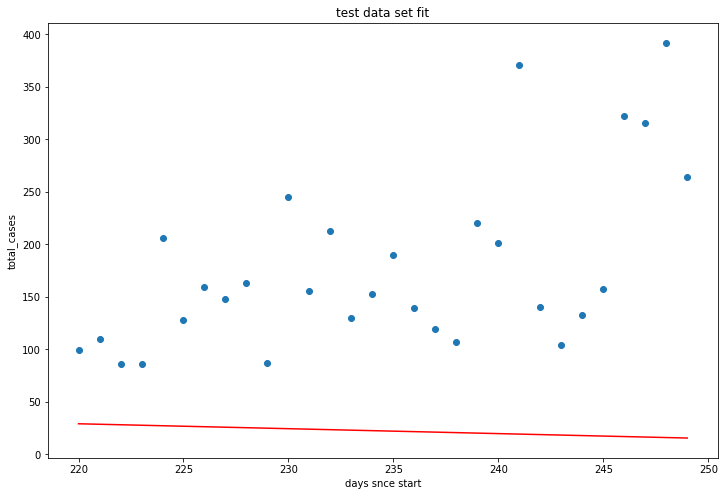

In [ ]:
linear_plots(daily_model,X_test,y_test,xlabel='days snce start',ylabel='total_cases',title='test data set fit')

,interval,total_cases
2020-12-06,250,15.079208
2020-12-07,251,14.610927
2020-12-08,252,14.142646
2020-12-09,253,13.674364
2020-12-10,254,13.206083
2020-12-11,255,12.737802
2020-12-12,256,12.269520
2020-12-13,257,11.801239
2020-12-14,258,11.332958
2020-12-15,259,10.864677


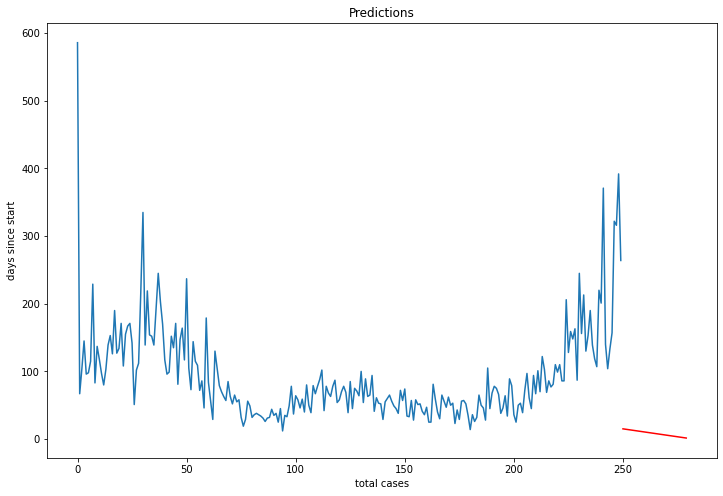

In [ ]:
linear_predictions = forecast_linear_reg(daily_model,resampled_cases_daily,periods=30)
linear_predictions

In [ ]:
linear_predictions['total_cases'].describe()

count    30.000000
mean      8.289130
std       4.122471
min       1.499051
25%       4.894090
50%       8.289130
75%      11.684169
max      15.079208
Name: total_cases, dtype: float64

#Model 2: Regression using higher order polynomials

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=3)
X_train_poly_transformed = poly_reg.fit_transform(X_train)
X_test_poly_transformed = poly_reg.fit_transform(X_test)

In [ ]:
poly_regressor = LinearRegression()
poly_regressor.fit(X_train_poly_transformed, y_train);

In [ ]:
poly_predict = poly_regressor.predict(X_train_poly_transformed)

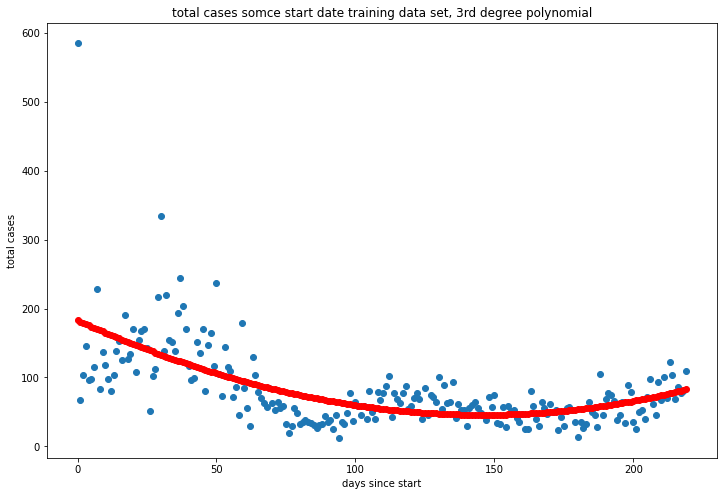

In [ ]:
fig,ax = plt.subplots(figsize=(12,8))
plt.scatter(X_train,y_train)
plt.scatter(X_train,poly_predict,color='red')
plt.xlabel('days since start')
plt.ylabel('total cases')
plt.title('total cases somce start date training data set, 3rd degree polynomial');

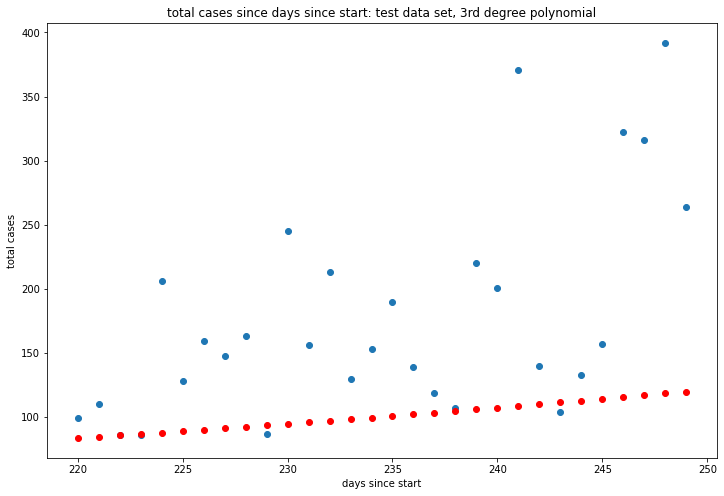

In [ ]:
fig,ax = plt.subplots(figsize=(12,8))
plt.scatter(X_test,y_test)
plt.scatter(X_test,poly_regressor.predict(poly_reg.fit_transform(X_test)),color='red')
plt.xlabel('days since start')
plt.ylabel('total cases')
plt.title('total cases since days since start: test data set, 3rd degree polynomial');

In [ ]:
#Get RMSE for 2nd model

poly_reg_mse = mean_squared_error(y_test,poly_regressor.predict(X_test_poly_transformed),squared=False)
poly_r2 = poly_regressor.score(X_test_poly_transformed,y_test)
print(f'R2 for this model is {round(poly_r2,2)}')
print(f'RMSE for this model is {round(poly_reg_mse,2)}')


R2 for this model is -1.41
RMSE for this model is 127.53


,interval,total_cases
2020-12-06,250,121.379222
2020-12-07,251,122.866102
2020-12-08,252,124.367915
2020-12-09,253,125.884673
2020-12-10,254,127.416391
2020-12-11,255,128.963082
2020-12-12,256,130.524759
2020-12-13,257,132.101435
2020-12-14,258,133.693125
2020-12-15,259,135.299841


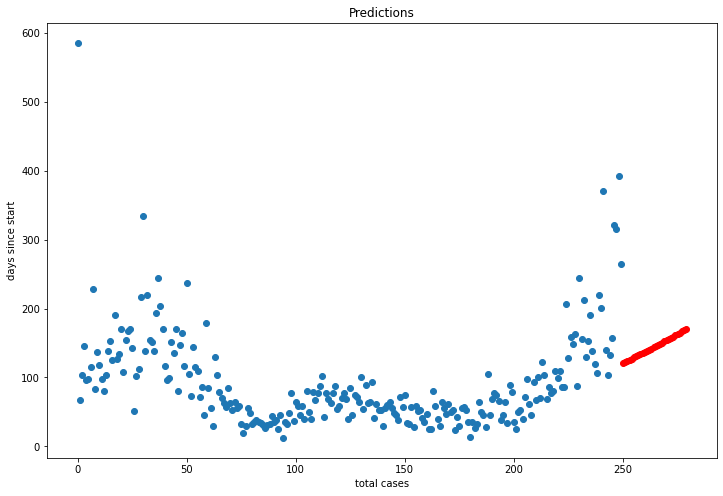

In [ ]:
forecast_poly_reg(poly_regressor, resampled_cases_daily, periods = 30)

count     30.000000
mean     144.972105
std       14.952244
min      121.379222
25%      132.499358
50%      144.407866
75%      157.109835
max      170.610352
Name: total_cases, dtype: float64

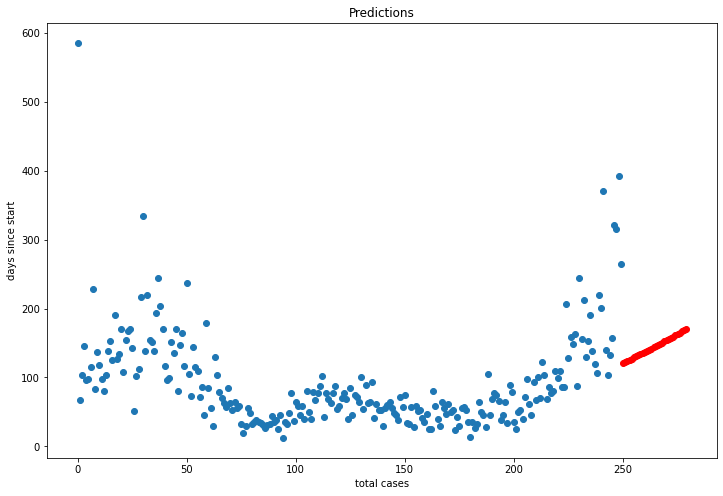

In [ ]:
poly_forecast_df = forecast_poly_reg(poly_regressor, resampled_cases_daily, periods = 30)
poly_forecast_df['total_cases'].describe()

# -- time series --

In [ ]:
#30 day time-test

time_train = resampled_cases_daily[:-60]
time_test = resampled_cases_daily[-60:]

# Model 4: Time Series - exploration using moving averages


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


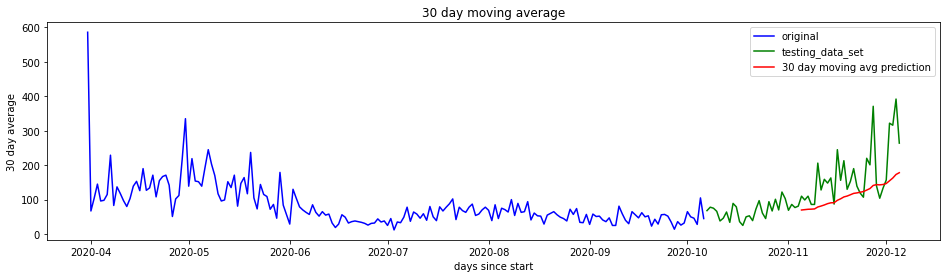

In [ ]:
resampled_cases_daily
moving_average_window = 30

ma_plot = time_test 
#ma_plot['days_since_start']  = [x for x in range(len(ma_plot))]
ma_plot['30_day_moving_average'] = ma_plot['total_cases'].rolling(moving_average_window).mean()

fig,ax = plt.subplots(figsize=(16,4))
plt.plot(time_train.index,time_train['total_cases'], color='blue', label='original')
plt.plot(time_test.index,time_test['total_cases'], color='green', label='testing_data_set')
plt.plot(time_test.index,ma_plot['30_day_moving_average'],color='red',label='30 day moving avg prediction')
plt.ylabel('30 day average')
plt.xlabel('days since start')
plt.title('30 day moving average')
plt.legend();

In [ ]:
ma_mse = mean_squared_error(time_test.loc['2020-11-05':]['total_cases'],ma_plot['30_day_moving_average'].dropna(), squared=False)
print(f'RMSE: {ma_mse}')

RMSE: 90.69693912710115


In [ ]:

thirty_day_avg = np.mean(resampled_cases_daily['total_cases'][-30:].values)
print(f'Thirty Day Avg {thirty_day_avg}')

vals_last_30 = resampled_cases_daily['total_cases'][-30:].values.tolist()
ave_predictions = []

for i in range(30):
  run_sum = 0 
  if i == 0:
    ave_predictions.append(thirty_day_avg)
  else:
    run_sum = sum(vals_last_30[i:]) + sum(ave_predictions[:(i-1)])
    ave_predictions.append(run_sum/30)


Thirty Day Avg 178.13333333333333


In [ ]:
ma_predictions = pd.DataFrame({'total_cases': ave_predictions},index=pd.date_range(start='12/06/2020', periods=30, freq='D'))
ma_predictions.describe()

,total_cases
count,30.000000
mean,189.549333
std,6.927594
min,174.833333
25%,185.074042
50%,190.253084
75%,195.331867
max,200.238986


In [ ]:
ma_predictions['2020-12-06':]

,total_cases
2020-12-06,178.133333
2020-12-07,174.833333
2020-12-08,177.104444
2020-12-09,180.065556
2020-12-10,183.102370
2020-12-11,182.237889
2020-12-12,184.074635
2020-12-13,184.849231
2020-12-14,186.051719
2020-12-15,186.780026


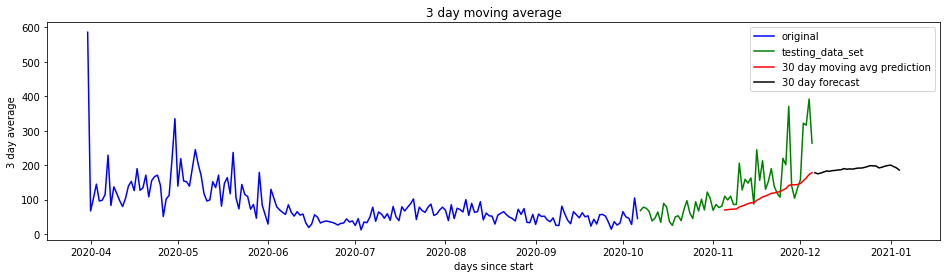

In [ ]:
fig,ax = plt.subplots(figsize=(16,4))
plt.plot(time_train.index,time_train['total_cases'], color='blue', label='original')
plt.plot(time_test.index,time_test['total_cases'], color='green', label='testing_data_set')
plt.plot(time_test.index,ma_plot['30_day_moving_average'],color='red',label='30 day moving avg prediction')
plt.plot(ma_predictions.index,ma_predictions['total_cases'],color='black',label='30 day forecast')
plt.ylabel('3 day average')
plt.xlabel('days since start')
plt.title('30 day moving average')
plt.legend();

In [ ]:
ma_predictions.head()

,total_cases
2020-12-06,324.000000
2020-12-07,218.666667
2020-12-08,196.000000
2020-12-09,246.222222
2020-12-10,220.296296


In [ ]:
ma_predictions.tail(50)

,total_cases
2020-12-06,324.000000
2020-12-07,218.666667
2020-12-08,196.000000
2020-12-09,246.222222
2020-12-10,220.296296
2020-12-11,220.839506
2020-12-12,229.119342
2020-12-13,223.418381
2020-12-14,224.459076
2020-12-15,225.665600


# Model 5: Simple exponential smoothing


In [ ]:

time_train = resampled_cases_daily[:-30]
time_test = resampled_cases_daily[-30:]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


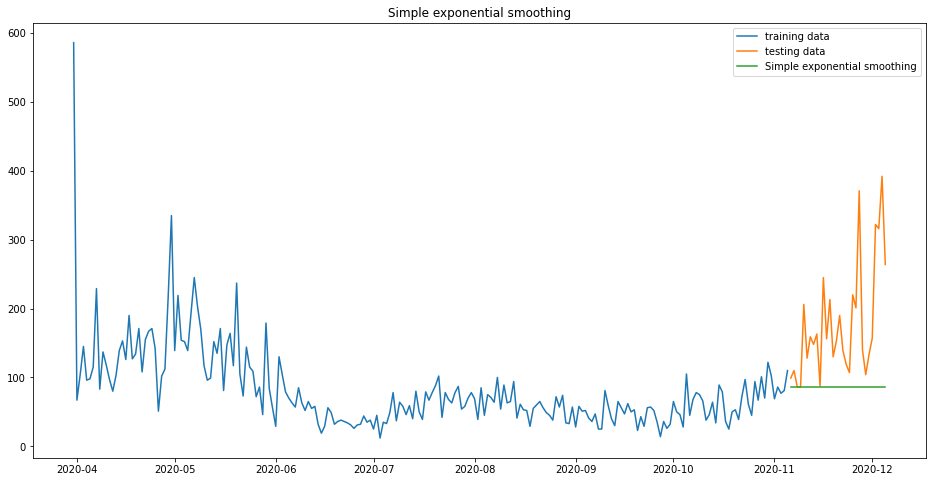

In [ ]:
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import ExponentialSmoothing

ses = time_test.copy()
fit = SimpleExpSmoothing(np.asarray(time_train['total_cases'])).fit()
ses['forecast'] = fit.forecast(len(ses))

plt.figure(figsize=(16,8))
plt.plot(time_train['total_cases'], label='training data')
plt.plot(time_test['total_cases'], label='testing data')
plt.plot(ses['forecast'], label='Simple exponential smoothing')
plt.legend(loc='best')
plt.title('Simple exponential smoothing')
plt.show()

In [ ]:
ses['total_cases'].describe()

count     30.000000
mean     178.133333
std       83.471545
min       86.000000
25%      121.250000
50%      154.500000
75%      211.250000
max      392.000000
Name: total_cases, dtype: float64

In [ ]:
rms = mean_squared_error(time_test['total_cases'], ses['forecast'],squared=False)
print(f'RMS is {rms}')



RMS is 123.66562088371217


# Model 6: Seasonal decomposition / Holt linear fitting

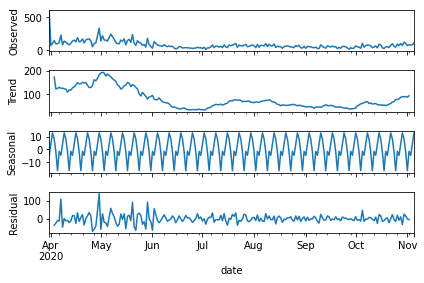

In [ ]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(time_train['total_cases']).plot()
result = sm.tsa.stattools.adfuller(time_train['total_cases'])
plt.show()

In [ ]:
holt_linear_forecast = pd.DataFrame({'total_cases': np.nan}, index=pd.date_range(start='12/05/2020', periods=30, freq='D'))

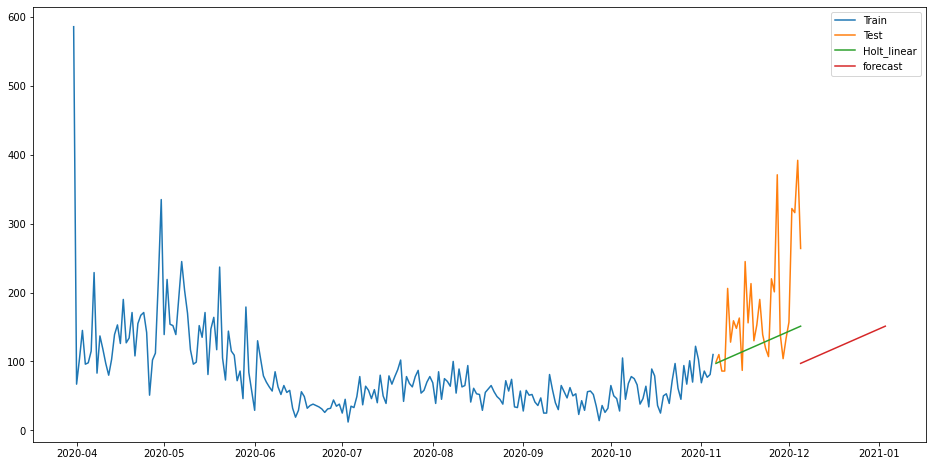

In [ ]:
from statsmodels.tsa.api import Holt

holt = time_test.copy()
fit = Holt(np.asarray(time_train['total_cases'])).fit(smoothing_level = 0.4,smoothing_slope = 0.1)
holt['forecast'] = fit.forecast(len(holt))
holt_linear_forecast['total_cases'] = fit.forecast(len(holt_linear_forecast))

plt.figure(figsize=(16,8))
plt.plot(time_train['total_cases'], label='Train')
plt.plot(time_test['total_cases'], label='Test')
#plt.plot(holt['forecast'], label='Holt_linear')
plt.plot(holt_linear_forecast['total_cases'],label='forecast')
plt.legend(loc='best')
plt.show()

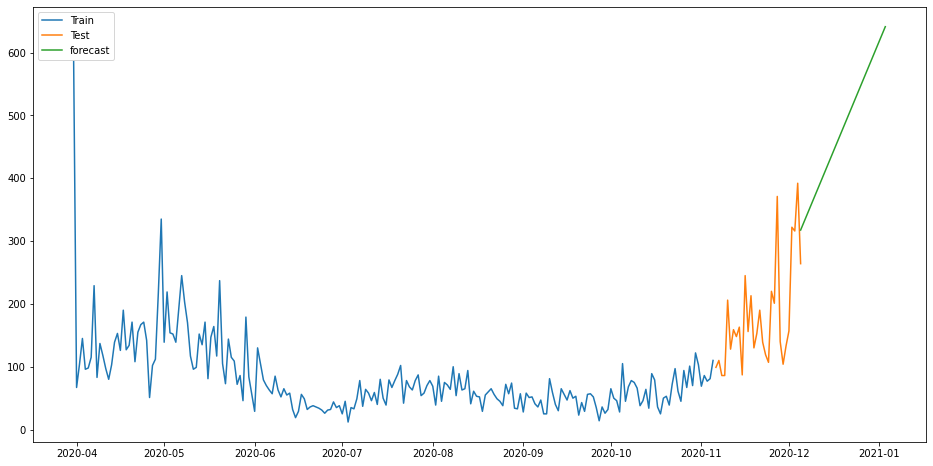

In [ ]:
from statsmodels.tsa.api import Holt

holt = time_test.copy()
fit = Holt(np.asarray(resampled_cases_daily['total_cases'])).fit(smoothing_level = 0.4,smoothing_slope = 0.1)
holt['forecast'] = fit.forecast(len(holt))
holt_linear_forecast['total_cases'] = fit.forecast(len(holt_linear_forecast))

plt.figure(figsize=(16,8))
plt.plot(time_train['total_cases'], label='Train')
plt.plot(time_test['total_cases'], label='Test')
#plt.plot(holt['forecast'], label='Holt_linear')
plt.plot(holt_linear_forecast['total_cases'],label='forecast')
plt.legend(loc='best')
plt.show()

In [ ]:
rms = mean_squared_error(time_test['total_cases'], holt['forecast'],squared=False)
print(f'RMS is {rms}')

RMS is 91.55581293210813


In [ ]:
holt_linear_forecast['2020-12-16':]

,total_cases
2020-12-16,440.231282
2020-12-17,451.392243
2020-12-18,462.553204
2020-12-19,473.714165
2020-12-20,484.875127
2020-12-21,496.036088
2020-12-22,507.197049
2020-12-23,518.358010
2020-12-24,529.518971
2020-12-25,540.679933


In [ ]:
holt['forecast'].describe()

count     30.000000
mean     123.934257
std       16.447304
min       96.844079
25%      110.389168
50%      123.934257
75%      137.479346
max      151.024436
Name: forecast, dtype: float64

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
                        
low_rms, sp = 0,0
for i in range(2,51):
 
    
  exp_smoothing = time_test.copy()
  fit = ExponentialSmoothing(np.asarray(time_train['total_cases']) , seasonal_periods=i, trend='mul', seasonal='mul').fit()
  exp_smoothing['forecast'] = fit.forecast(len(exp_smoothing))
  
  rms = mean_squared_error(time_test['total_cases'], exp_smoothing['forecast'],squared=False)
  
  if i == 2:
    low_rms = rms
    sp = i
  else:
    if rms < low_rms:
      low_rms = rms
      sp = i
  

In [ ]:
print(f'best seasonal param {sp}')

best seasonal param 5


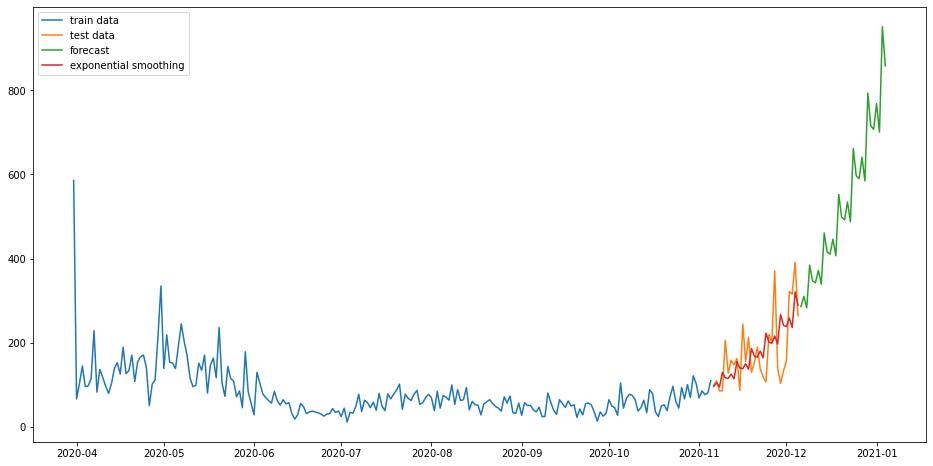

RMS is 68.90220360366573


In [ ]:
exp_smoothing = time_test.copy()
fit = ExponentialSmoothing(np.asarray(time_train['total_cases']) , seasonal_periods=5, trend='mul', seasonal='mul').fit()
exp_smoothing['forecast'] = fit.forecast(len(exp_smoothing))




plt.figure(figsize=(16,8))
plt.plot(time_train['total_cases'], label='train data')
plt.plot(time_test['total_cases'], label='test data')
plt.plot(exp_smoothing_forecast['total_cases'],label='forecast')


plt.plot(exp_smoothing['forecast'], label='exponential smoothing')
plt.legend(loc='best')
plt.show()

rms = mean_squared_error(time_test['total_cases'], exp_smoothing['forecast'],squared=False)
print(f'RMS is {rms}')

In [ ]:
exp_30_day_forecast = fit.forecast(60)
exp_30_day_forecast = exp_30_day_forecast[-30:]

exp_smoothing_forecast = pd.DataFrame({'total_cases': exp_30_day_forecast}, index=pd.date_range(start='12/06/2020', periods=30, freq='D'))
exp_smoothing_forecast['2020-12-16':]


,total_cases
2020-12-16,410.768016
2020-12-17,446.194773
2020-12-18,406.891526
2020-12-19,552.381449
2020-12-20,498.258619
2020-12-21,492.304454
2020-12-22,534.763334
2020-12-23,487.658490
2020-12-24,662.027803
2020-12-25,597.161725


In [ ]:
exp_smoothing_forecast.describe()

,total_cases
count,30.000000
mean,531.328911
std,178.580030
min,283.272462
25%,390.143338
50%,495.281536
75%,656.748987
max,950.934310


In [ ]:
exp_smoothing_forecast

,total_cases
2020-12-06,285.971223
2020-12-07,310.634859
2020-12-08,283.272462
2020-12-09,384.560609
2020-12-10,346.881015
2020-12-11,342.735805
2020-12-12,372.295112
2020-12-13,339.501347
2020-12-14,460.894941
2020-12-15,415.736041


# ARIMA


In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 4.8MB/s 
     |████████████████████████████████| 2.1MB 17.8MB/s 
     |████████████████████████████████| 9.5MB 24.1MB/s 
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
arima_model = auto_arima(time_train['total_cases'],error_action='ignore', m=30, trace=1, seasonal=True, maxiter=100)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=inf, Time=9.55 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=2365.461, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=2308.039, Time=1.92 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=2276.836, Time=1.67 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=2363.827, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[30] intercept   : AIC=2298.571, Time=0.09 sec
 ARIMA(0,1,1)(1,0,1)[30] intercept   : AIC=2276.201, Time=2.36 sec
 ARIMA(0,1,1)(1,0,0)[30] intercept   : AIC=2274.602, Time=1.29 sec
 ARIMA(0,1,1)(2,0,0)[30] intercept   : AIC=2276.128, Time=6.29 sec
 ARIMA(0,1,1)(2,0,1)[30] intercept   : AIC=2278.076, Time=12.94 sec
 ARIMA(0,1,0)(1,0,0)[30] intercept   : AIC=2344.166, Time=1.57 sec
 ARIMA(1,1,1)(1,0,0)[30] intercept   : AIC=2276.596, Time=1.73 sec
 ARIMA(0,1,2)(1,0,0)[30] intercept   : AIC=2276.596, Time=2.07 sec
 ARIMA(1,1,2)(1,0,0)[30] intercept   : AIC=inf, Time=5.19 sec
 ARIMA(0,1,1)(1,0,0)[30]    

In [ ]:
arima_model

ARIMA(maxiter=100, method='lbfgs', order=(2, 1, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [ ]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  220
Model:             SARIMAX(0, 1, 1)x(1, 0, 0, 30)   Log Likelihood               -1133.357
Date:                            Sun, 20 Dec 2020   AIC                           2272.715
Time:                                    14:51:24   BIC                           2282.882
Sample:                                         0   HQIC                          2276.821
                                            - 220                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8020      0.043    -18.653      0.000      -0.886      -0.718
ar.S.L30       0.4863      0.042     11.596      0.000       0.404       0.569
sigma2      1758.3218     98.104     17.923      0.000    1566.041    1950.602
===================================================================================
Ljung-Box (Q):                       91.55   Jarque-Bera (JB):              4825.45
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                            -3.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
fit = sm.tsa.statespace.SARIMAX(time_train['total_cases'],order=(0,1,1),seasonal_order=(1,0,0,30)).fit()

In [ ]:
arima_df = time_test.copy()
arima_df

,total_cases,weeks_since_start,3_day_moving_average
date,,,
2020-11-06,99,220,NaN
2020-11-07,110,221,NaN
2020-11-08,86,222,98.333333
2020-11-09,86,223,94.000000
2020-11-10,206,224,126.000000
2020-11-11,128,225,140.000000
2020-11-12,159,226,164.333333
2020-11-13,148,227,145.000000
2020-11-14,163,228,156.666667


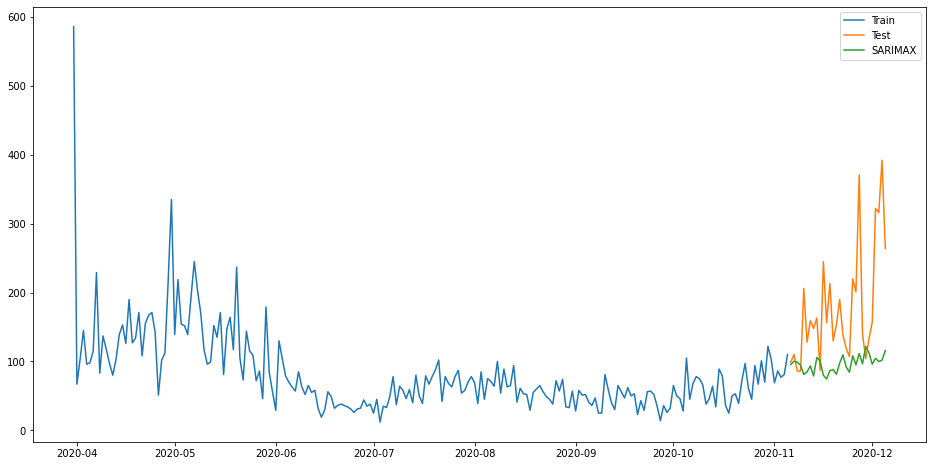

RMSE: 114.8224879565005


In [ ]:
arima_df['forecast'] = fit.predict(start='2020-11-06',end='2020-12-05')
plt.figure(figsize=(16,8))
plt.plot(time_train['total_cases'], label='Train')
plt.plot(time_test['total_cases'], label='Test')
plt.plot(arima_df['forecast'], label='SARIMAX')
plt.legend(loc='best')
plt.show()

rms = mean_squared_error(time_test['total_cases'], arima_df['forecast'],squared=False)
print(f'RMSE: {rms}')



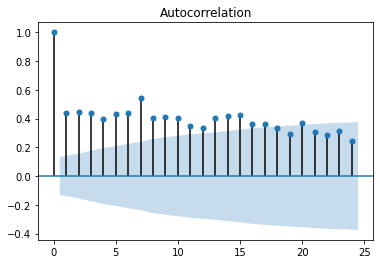

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(time_train['total_cases']);
#p = 17

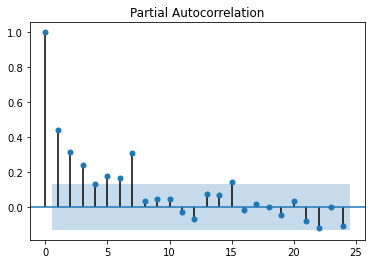

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(time_train['total_cases']);
#q = 7

In [ ]:
arima_model = auto_arima(resampled_cases_daily['total_cases'],error_action='ignore', m=30, trace=1, seasonal=True, maxiter=100)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=inf, Time=14.21 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=2734.179, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=2677.633, Time=1.91 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=2649.922, Time=2.03 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=2732.302, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[30] intercept   : AIC=2663.999, Time=0.11 sec
 ARIMA(0,1,1)(1,0,1)[30] intercept   : AIC=2648.968, Time=2.59 sec
 ARIMA(0,1,1)(1,0,0)[30] intercept   : AIC=2646.973, Time=1.72 sec
 ARIMA(0,1,1)(2,0,0)[30] intercept   : AIC=2648.966, Time=8.84 sec
 ARIMA(0,1,1)(2,0,1)[30] intercept   : AIC=inf, Time=26.47 sec
 ARIMA(0,1,0)(1,0,0)[30] intercept   : AIC=2716.770, Time=1.77 sec
 ARIMA(1,1,1)(1,0,0)[30] intercept   : AIC=2647.084, Time=2.11 sec
 ARIMA(0,1,2)(1,0,0)[30] intercept   : AIC=2647.296, Time=2.50 sec
 ARIMA(1,1,2)(1,0,0)[30] intercept   : AIC=inf, Time=5.84 sec
 ARIMA(0,1,1)(1,0,0)[30]        

In [ ]:
fit = sm.tsa.statespace.SARIMAX(resampled_cases_daily['total_cases'],order=(0,1,1),seasonal_order=(1,0,0,30)).fit()

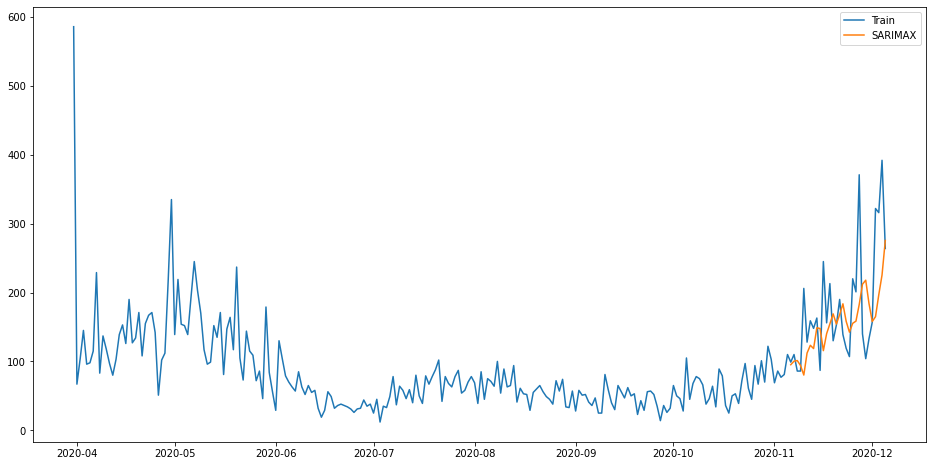

RMSE: 77.17902635480571


In [ ]:
arima_df = time_test.copy()
arima_df
arima_df['forecast'] = fit.predict(start='2020-11-06',end='2020-12-05')
plt.figure(figsize=(16,8))
plt.plot(resampled_cases_daily['total_cases'], label='Train')
#plt.plot(time_test['total_cases'], label='Test')
plt.plot(arima_df['forecast'], label='SARIMAX')
plt.legend(loc='best')
plt.show()

rms = mean_squared_error(time_test['total_cases'], arima_df['forecast'],squared=False)
print(f'RMSE: {rms}')



In [ ]:
arima_predictions = pd.DataFrame({'total_cases': np.nan},index=pd.date_range(start='12/06/2020', periods=30, freq='D'))

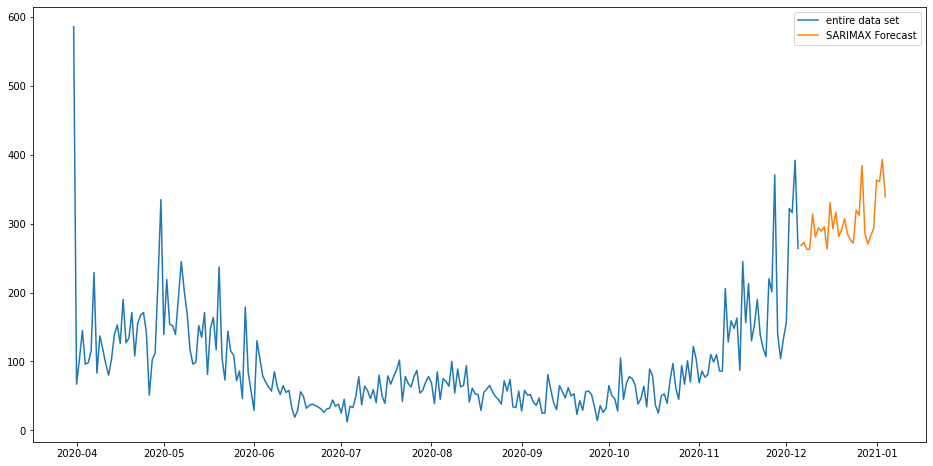

In [ ]:
arima_predictions = arima_df.append(arima_predictions)
arima_predictions

arima_predictions['forecast'] = fit.predict(start='2020-12-06',end='2021-01-04')
plt.figure(figsize=(16,8))
plt.plot(resampled_cases_daily['total_cases'], label='entire data set')
#plt.plot(time_test['total_cases'], label='Test')
plt.plot(arima_predictions['forecast'], label='SARIMAX Forecast')
plt.legend(loc='best')
plt.show()

In [ ]:
arima_predictions['2020-12-06':]['forecast'].describe()

count     30.000000
mean     302.029426
std       35.597027
min      262.738518
25%      277.771129
50%      291.950825
75%      316.152261
max      393.234368
Name: forecast, dtype: float64

In [ ]:
arima_predictions['2020-12-06':]

,total_cases,weeks_since_start,3_day_moving_average,forecast
2020-12-06,NaN,NaN,NaN,268.282460
2020-12-07,NaN,NaN,NaN,272.973487
2020-12-08,NaN,NaN,NaN,262.738518
2020-12-09,NaN,NaN,NaN,262.738518
2020-12-10,NaN,NaN,NaN,313.913361
2020-12-11,NaN,NaN,NaN,280.649713
2020-12-12,NaN,NaN,NaN,293.869881
2020-12-13,NaN,NaN,NaN,289.178854
2020-12-14,NaN,NaN,NaN,295.575709
2020-12-15,NaN,NaN,NaN,263.164975
